<a href="https://colab.research.google.com/github/Jordano-Jackson/MLStudy/blob/main/GAN/GAN/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [2]:
latent_dim = 100

# generator class define
class Generator(nn.Module) :
  def __init__(self) :
    super(Generator, self).__init__();

    def block(input_dim, output_dim, normalize=True) :
      layers = [nn.Linear(input_dim,output_dim)]
      if(normalize) :
        # batch normalization
        layers.append(nn.BatchNorm1d(output_dim, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True));
      return layers
    
    self.model = nn.Sequential(
        *block(latent_dim, 128, normalize=False),
        *block(128,256),
        *block(256,512),
        *block(512,1024),
        nn.Linear(1024, 1*28*28),
        nn.Tanh()
    )

  def forward (self, z) :
    img = self.model(z)
    img = img.view(img.size(0), 1,28,28)
    return img

In [3]:
# discriminator class define
class Discriminator(nn.Module) :
  def __init__(self) :
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(1*28*28, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid(),
    )

  # do discrimination on image
  def forward(self, img) :
    flattened = img.view(img.size(0),-1)
    output = self.model(flattened);

    return output

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# Loss function
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

lr = 2e-4

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))



In [6]:
import time

n_epochs = 200
sample_interval = 2000
start_time = time.time()

for epoch in range(n_epochs) :
  for i ,(imgs,_) in enumerate(dataloader) :

    real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

    real_imgs = imgs.cuda()

    # learn generator
    optimizer_G.zero_grad()

    z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

    generated_imgs = generator(z)

    g_loss = adversarial_loss(discriminator(generated_imgs),real)

    g_loss.backward()
    optimizer_G.step()

    # learn discriminator
    optimizer_D.zero_grad()

    real_loss = adversarial_loss(discriminator(real_imgs),real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()),fake)
    d_loss = (real_loss + fake_loss)/2;

    d_loss.backward()
    optimizer_D.step()

    done = epoch * len(dataloader) + i
    if(done % sample_interval == 0) :
      save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

  print(f"[Epoch {epoch}/{n_epochs}] D loss : {d_loss.item():.6f}] [G loss : {g_loss.item():.6f}] [Elapsed time : {time.time() - start_time:.2f}s]")



[Epoch 0/200] D loss : 0.403336] [G loss : 0.972622] [Elapsed time : 15.67s]
[Epoch 1/200] D loss : 0.483842] [G loss : 0.698530] [Elapsed time : 28.85s]
[Epoch 2/200] D loss : 0.496625] [G loss : 0.572085] [Elapsed time : 42.43s]
[Epoch 3/200] D loss : 0.425921] [G loss : 0.758489] [Elapsed time : 55.88s]
[Epoch 4/200] D loss : 0.314624] [G loss : 1.642886] [Elapsed time : 69.41s]
[Epoch 5/200] D loss : 0.339111] [G loss : 3.184644] [Elapsed time : 82.82s]
[Epoch 6/200] D loss : 0.266328] [G loss : 1.189005] [Elapsed time : 96.09s]
[Epoch 7/200] D loss : 0.301432] [G loss : 1.046898] [Elapsed time : 109.48s]
[Epoch 8/200] D loss : 0.295894] [G loss : 1.695290] [Elapsed time : 122.75s]
[Epoch 9/200] D loss : 0.229520] [G loss : 2.687885] [Elapsed time : 136.05s]
[Epoch 10/200] D loss : 0.293808] [G loss : 2.170074] [Elapsed time : 149.18s]
[Epoch 11/200] D loss : 0.324946] [G loss : 2.324952] [Elapsed time : 162.48s]
[Epoch 12/200] D loss : 0.339136] [G loss : 2.794149] [Elapsed time :

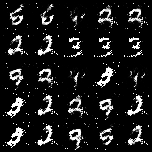

In [14]:
from IPython.display import Image
Image('93799.png')

In [12]:
save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

## Reference
* https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/GAN_for_MNIST_Tutorial.ipynb